## 1. Setup and Imports

*Importing necessary libraries (pandas, numpy, sklearn, visualization tools) and configuring warnings.*


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import time

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import xgboost as xgb
from lightgbm import LGBMClassifier

# --- Warning Filters ---
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.preprocessing._encoders')
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost.training')
warnings.filterwarnings('ignore', message="X does not have valid feature names, but LGBMClassifier was fitted with feature names")

## 2. Data Loading and Preparation

*Loading the employee survey dataset, performing initial cleaning (dropping EmpID, handling boolean 'haveOT'), and preparing the target variable ('JobSatisfaction').*

In [ ]:
print("--- Loading & Preparing Data ---")
df = pd.read_csv('employee_survey.csv')
df = df.drop('EmpID', axis=1)
df['haveOT'] = df['haveOT'].map({True: 1, False: 0})
df['JobSatisfaction'] = df['JobSatisfaction'] - 1 # 0-based index
TARGET = 'JobSatisfaction'
print(f"Data shape: {df.shape}")

--- Loading & Preparing Data ---
Data shape: (3025, 22)


## 3. Exploratory Data Analysis (EDA)

*Performing initial analysis to understand data characteristics, including checking for missing values and visualizing the distribution of the target variable (Job Satisfaction).*

Missing Values Check: 0

Target Variable Distribution (JobSatisfaction):
JobSatisfaction
0    0.137851
1    0.091570
2    0.187107
3    0.412893
4    0.170579
Name: proportion, dtype: float64


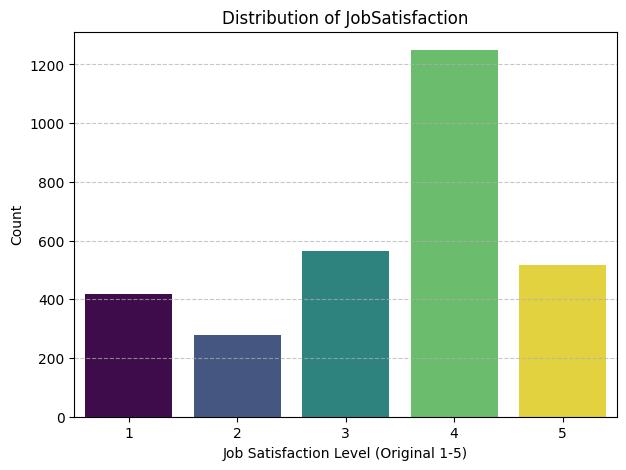

In [ ]:
print("Missing Values Check:", df.isnull().sum().sum())
print(f"\nTarget Variable Distribution ({TARGET}):")
print(df[TARGET].value_counts(normalize=True).sort_index())
plt.figure(figsize=(7, 5))
sns.countplot(x=TARGET, data=df, palette='viridis', hue=TARGET, legend=False)
plt.title(f'Distribution of {TARGET}')
plt.xticks(ticks=range(5), labels=[str(i) for i in range(1, 6)])
plt.xlabel("Job Satisfaction Level (Original 1-5)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Numerical Feature Distributions:


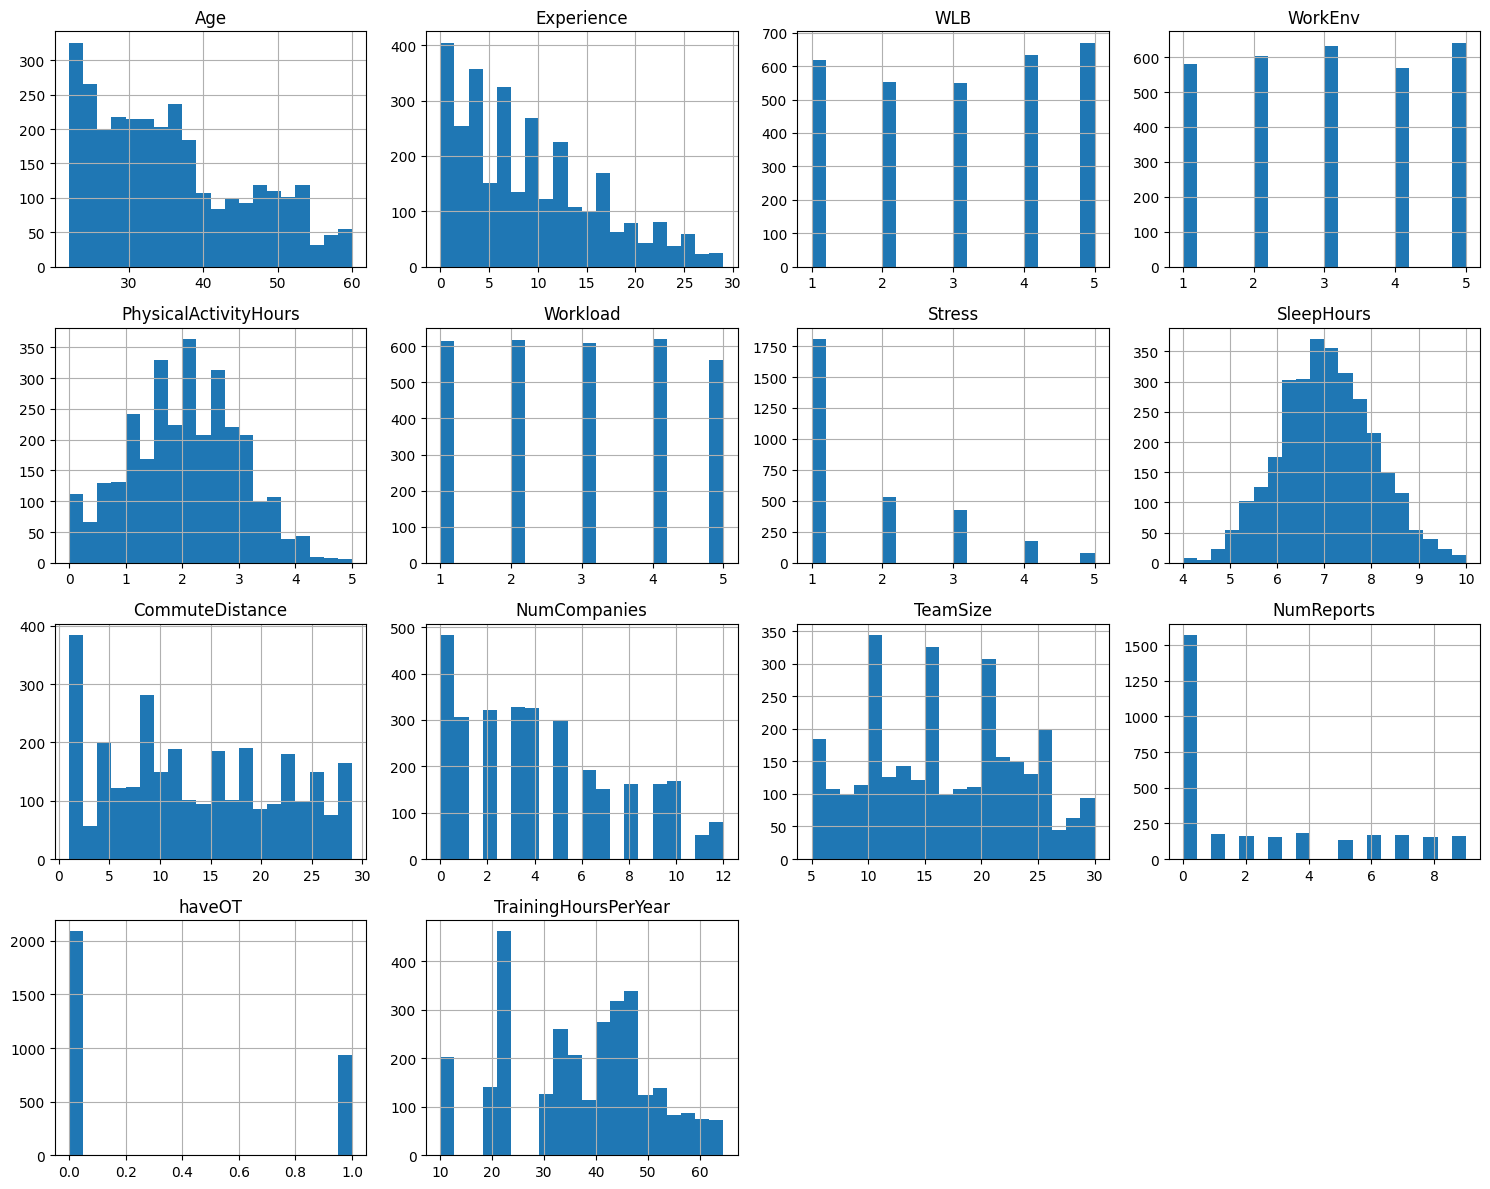

In [ ]:
print("\nNumerical Feature Distributions:")
numerical_eda = df.select_dtypes(include=np.number).drop(TARGET, axis=1)
numerical_eda.hist(figsize=(15, 12), bins=20, layout=(-1, 4))
plt.tight_layout()
plt.show()


Categorical Feature Distributions:


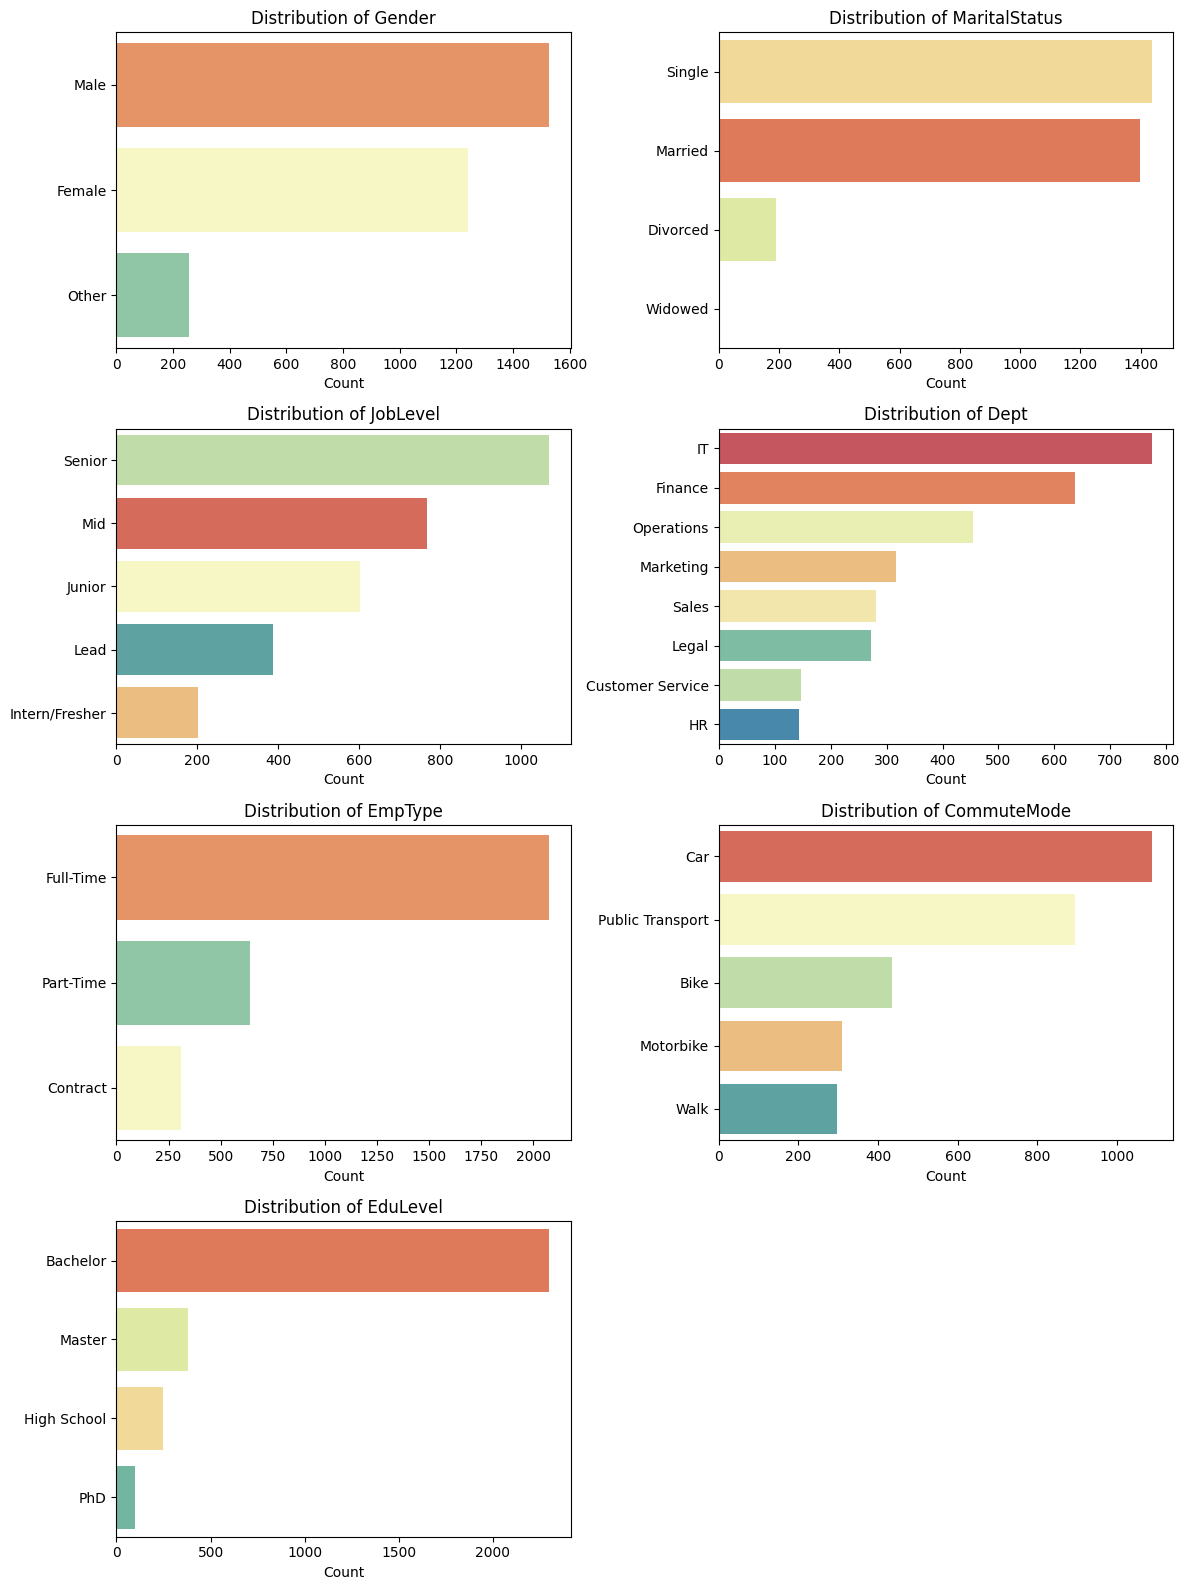

In [ ]:
print("\nCategorical Feature Distributions:")
categorical_eda = df.select_dtypes(include='object')
# Calculate necessary rows for subplots more robustly
n_cols = 2
n_rows = (len(categorical_eda.columns) + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 4 * n_rows)) # Dynamic figsize
axes = axes.flatten()
for i, col in enumerate(categorical_eda.columns):
    order = df[col].value_counts().index
    sns.countplot(y=col, data=df, ax=axes[i], order=order, palette='Spectral', hue=col, legend=False) # Added hue
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('')
# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

## 4. Feature Preprocessing

*Defining numerical, nominal, and ordinal features. Setting up preprocessing pipelines using StandardScaler, OneHotEncoder, and OrdinalEncoder within a ColumnTransformer.*

In [ ]:
X = df.drop(TARGET, axis=1)
y = df[TARGET]

job_level_order = ['Intern/Fresher', 'Junior', 'Mid', 'Senior', 'Lead']
edu_level_order = ['High School', 'Bachelor', 'Master', 'PhD']
ordinal_features = ['JobLevel', 'EduLevel']
nominal_features = ['Gender', 'MaritalStatus', 'Dept', 'EmpType', 'CommuteMode']
numerical_features = ['Age', 'Experience', 'WLB', 'WorkEnv', 'PhysicalActivityHours',
                      'Workload', 'Stress', 'SleepHours', 'CommuteDistance', 'NumCompanies',
                      'TeamSize', 'NumReports', 'TrainingHoursPerYear', 'haveOT']

# Get all unique categories for each nominal feature - no imputation of values
nominal_categories = {feature: list(df[feature].unique()) for feature in nominal_features}
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False,handle_unknown='ignore',categories=[nominal_categories[feature] for feature in nominal_features]))])
ordinal_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder(categories=[job_level_order, edu_level_order], handle_unknown='use_encoded_value', unknown_value=-1)),
                                      ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('nom', nominal_transformer, nominal_features),
        ('ord', ordinal_transformer, ordinal_features)],
    remainder='passthrough', verbose_feature_names_out=False)

## 5. Data Splitting

*Splitting the dataset into training and testing sets (80-20 split) using stratified sampling to maintain target variable proportions.*

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (2420, 21), Test shape: (605, 21)


## 6. Model Training and Hyperparameter Tuning (GridSearchCV)

*Defining the baseline models with default parameters, setting up parameter grids for tuning, and executing GridSearchCV with 5-fold stratified cross-validation to find optimal hyperparameters for each model based on the weighted F1-score.*

In [ ]:
models_to_tune = {
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced'),
    'SVM': SVC(probability=True, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1, class_weight='balanced', n_jobs=-1)
}

Set up a simple grid search to perform tuning of parameters and define cross fold validation

In [ ]:
param_grids = {
    'Logistic Regression': { 'classifier__C': [0.1, 1, 10, 50] },
    'SVM': { 'classifier__C': [1, 10, 50], 'classifier__kernel': ['rbf', 'poly'], 'classifier__gamma': ['scale', 0.1, 0.01] },
    'Random Forest': { 'classifier__n_estimators': [100, 200, 300], 'classifier__max_depth': [10, 20, None], 'classifier__min_samples_leaf': [1, 3, 5, 15], 'classifier__class_weight': ['balanced', 'balanced_subsample'] },
    'XGBoost': { 'classifier__n_estimators': [100, 200, 300], 'classifier__max_depth': [3, 5, 7], 'classifier__learning_rate': [0.05, 0.1, 0.2] },
    'LightGBM': { 'classifier__n_estimators': [100, 200, 300], 'classifier__max_depth': [5, 10, -1], 'classifier__learning_rate': [0.05, 0.1], 'classifier__num_leaves': [20, 31, 40] }
}
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_results = {}
for name, model in models_to_tune.items():
    if name not in param_grids: continue
    print(f"  Running GridSearchCV for {name}...")
    start_time = time.time()
    pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', model)])
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_strategy, scoring='f1_weighted', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    grid_search_results[name] = {'best_score': grid_search.best_score_, 'best_params': grid_search.best_params_, 'best_estimator': grid_search.best_estimator_}
    print(f"    Best {name} CV F1 (Weighted): {grid_search_results[name]['best_score']:.4f} (Time: {time.time() - start_time:.2f}s)")
    print(f"    Best Params: {grid_search_results[name]['best_params']}")

  Running GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
    Best Logistic Regression CV F1 (Weighted): 0.3573 (Time: 4.65s)
    Best Params: {'classifier__C': 0.1}
  Running GridSearchCV for SVM...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
    Best SVM CV F1 (Weighted): 0.4714 (Time: 173.07s)
    Best Params: {'classifier__C': 50, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
  Running GridSearchCV for Random Forest...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
    Best Random Forest CV F1 (Weighted): 0.4880 (Time: 301.92s)
    Best Params: {'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 5, 'classifier__n_estimators': 200}
  Running GridSearchCV for XGBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
    Best XGBoost CV F1 (Weighted): 0.4742 (Time: 96.12s)
    Best Params: {'classifier__learning_rate': 0.1, 'cl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


    Best LightGBM CV F1 (Weighted): 0.4756 (Time: 685.59s)
    Best Params: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'classifier__num_leaves': 40}


## 7. Final Evaluation and Analysis of Top Models

*Selecting the top-performing model(s) based on cross-validation scores and evaluating their performance on the held-out test set.*

In [ ]:
print("Identifying Best Models based on Grid Search F1 Scores")

final_pipelines = {}
test_predictions = {}

if grid_search_results:
    # Create DataFrame from results and sort
    tuned_cv_scores_df = pd.DataFrame({
        name: result['best_score'] for name, result in grid_search_results.items()
    }, index=['Tuned CV F1']).T.sort_values('Tuned CV F1', ascending=False)

    print("\nTuned Model CV Scores (Sorted):")
    print(tuned_cv_scores_df.round(4))

    # Select top N models (up to 2)
    top_n = min(2, len(tuned_cv_scores_df)) # Ensure we don't try to get more models than available
    top_model_names = tuned_cv_scores_df.head(top_n).index.tolist()
    print(f"\nSelected Top {len(top_model_names)} Model(s) for Final Evaluation: {top_model_names}")

else:
    print("No models were tuned via GridSearchCV. Cannot proceed with final evaluation.")
    top_model_names = []

Identifying Best Models based on Grid Search F1 Scores

Tuned Model CV Scores (Sorted):
                     Tuned CV F1
Random Forest             0.4880
LightGBM                  0.4756
XGBoost                   0.4742
SVM                       0.4714
Logistic Regression       0.3573

Selected Top 2 Model(s) for Final Evaluation: ['Random Forest', 'LightGBM']


### 7.1 Test Set Performance

*Detailed classification report for the best performing models with GridSearch parameters on the unseen test data.*

In [ ]:
print("Evaluating Models on Test Set")

if not top_model_names:
    print("No models selected for evaluation.")
else:
    for model_name in top_model_names:
        print(f"\n Model Results: {model_name}")
        pipeline_to_eval = grid_search_results[model_name]['best_estimator']
        final_pipelines[model_name] = pipeline_to_eval # Store the final pipeline

        y_pred = pipeline_to_eval.predict(X_test)
        test_predictions[model_name] = y_pred # Store predictions

        print(classification_report(y_test, y_pred, target_names=[str(i) for i in range(1, 6)]))

Evaluating Models on Test Set

 Model Results: Random Forest
              precision    recall  f1-score   support

           1       0.50      0.85      0.63        84
           2       0.13      0.05      0.08        55
           3       0.33      0.26      0.29       113
           4       0.62      0.66      0.64       250
           5       0.41      0.33      0.37       103

    accuracy                           0.50       605
   macro avg       0.40      0.43      0.40       605
weighted avg       0.47      0.50      0.47       605


 Model Results: LightGBM
              precision    recall  f1-score   support

           1       0.48      0.64      0.55        84
           2       0.12      0.11      0.11        55
           3       0.30      0.28      0.29       113
           4       0.62      0.58      0.60       250
           5       0.36      0.36      0.36       103

    accuracy                           0.45       605
   macro avg       0.38      0.39      0.38 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### 7.2 Confusion Matrices

*Visualizing the confusion matrix for the best tuned model(s) to understand specific class prediction performance.*

Generating Confusion Matrices for Top Models


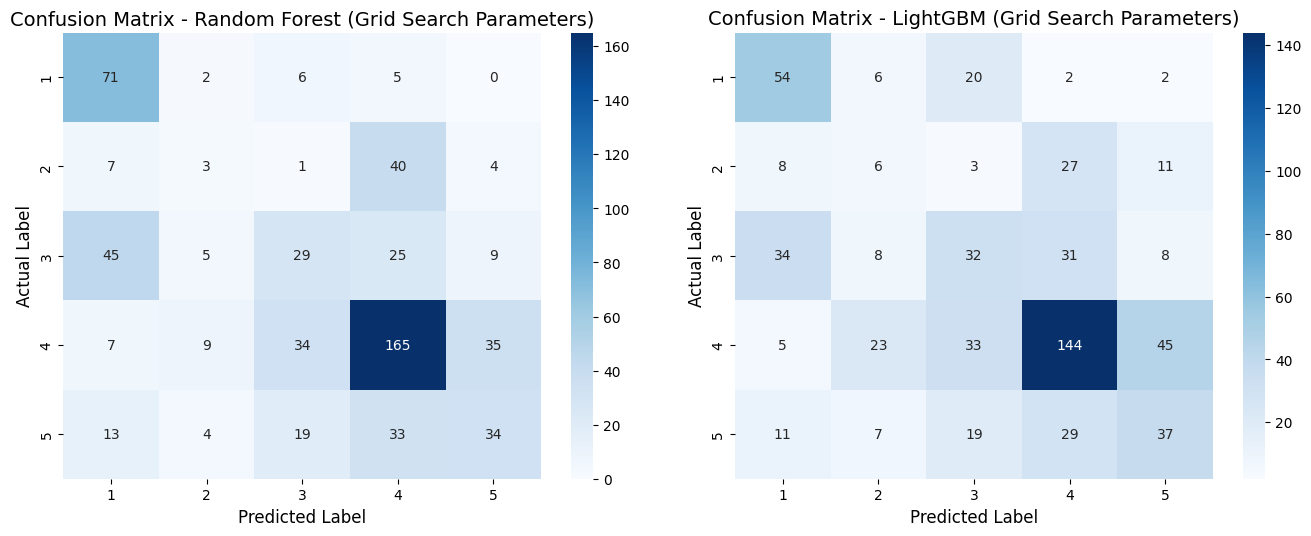

In [ ]:
# Plot Confusion Matrices
print("Generating Confusion Matrices for Top Models")

if not top_model_names:
    print("No models selected for confusion matrix plotting.")
else:
    n_models_to_plot = len(top_model_names)
    fig, axes = plt.subplots(1, n_models_to_plot, figsize=(7 * n_models_to_plot, 6), squeeze=False) # Adjust figsize dynamically

    for i, model_name in enumerate(top_model_names):
        ax = axes[0, i] # Get the specific subplot axis
        y_pred = test_predictions.get(model_name) # Retrieve predictions

        if y_pred is not None:
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=[str(i) for i in range(1,6)],
                        yticklabels=[str(i) for i in range(1,6)],
                        ax=ax)
            ax.set_title(f'Confusion Matrix - {model_name} (Grid Search Parameters)', fontsize=14)
            ax.set_xlabel('Predicted Label', fontsize=12)
            ax.set_ylabel('Actual Label', fontsize=12)
        else:
            ax.text(0.5, 0.5, 'Predictions not found', ha='center', va='center')
            ax.set_title(f'Confusion Matrix - {model_name} (Grid Search Parameters)', fontsize=14)

    plt.tight_layout(pad=3.0) # Add padding between subplots
    plt.show()

### 7.3 Feature Importance / Coefficient Analysis

*Examining feature importances (for tree-based models/XGBoost/LightGBM) or coefficient magnitudes (for Logistic Regression) of the best tuned model(s) to identify key predictors of Job Satisfaction.*

Analyzing Feature Importance/Coefficients for Top Models

--- Feature Analysis for: Random Forest ---


<ipython-input-14-bbfff7487099>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df.head(n_features_to_plot), palette='viridis')


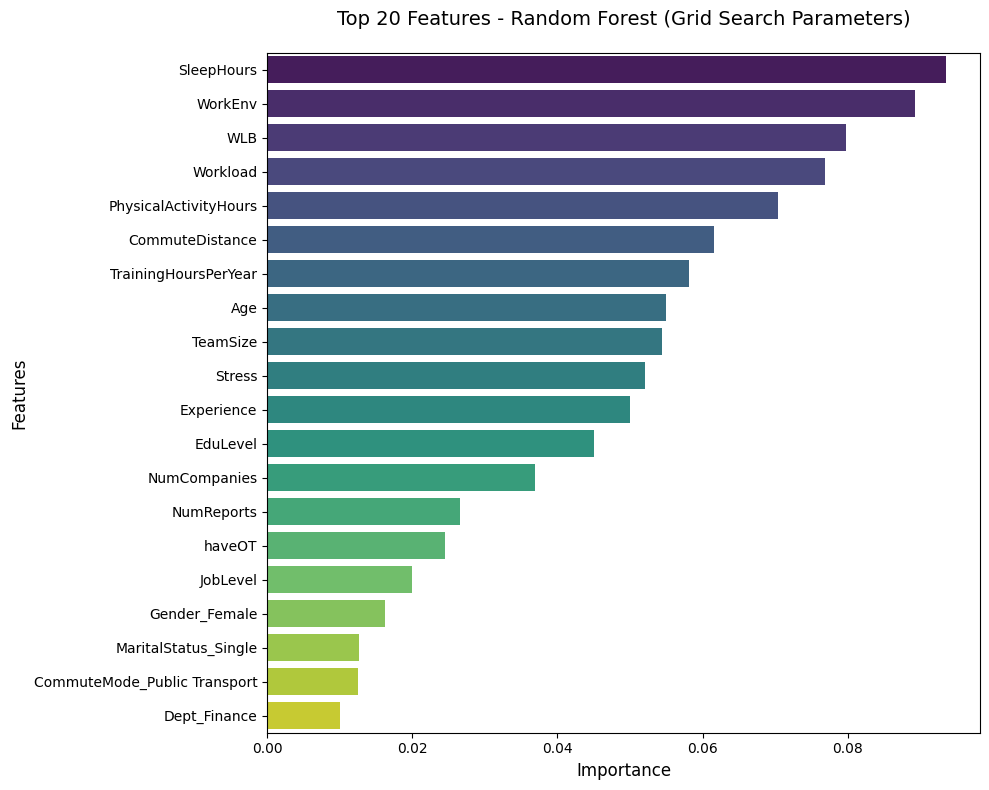


--- Feature Analysis for: LightGBM ---


<ipython-input-14-bbfff7487099>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df.head(n_features_to_plot), palette='viridis')


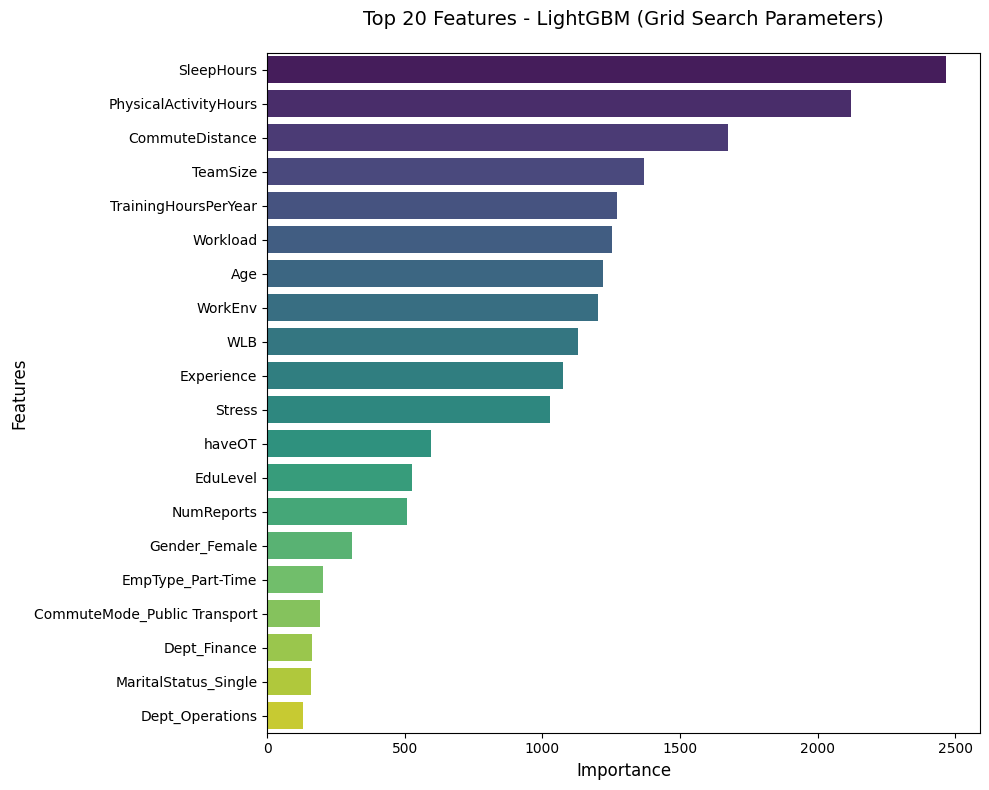

In [ ]:
# Analyze Feature Importance/Coefficients for Top Models
print("Analyzing Feature Importance/Coefficients for Top Models")

if not top_model_names:
    print("No models selected for feature analysis.")
else:
    n_features_to_plot = 20 # How many top features to show

    for model_name in top_model_names:
        print(f"\n--- Feature Analysis for: {model_name} ---")
        pipeline = final_pipelines.get(model_name)
        if pipeline is None:
            print(f"Could not find pipeline for {model_name}.")
            continue

        model_step = pipeline.named_steps['classifier']
        preprocessor_step = pipeline.named_steps['preprocessor']

        try:
            # Get feature names from the fitted preprocessor in the final pipeline
            feature_names_out_best = preprocessor_step.get_feature_names_out()

            # Check for feature_importances_ attribute
            if hasattr(model_step, 'feature_importances_'):
                importances = model_step.feature_importances_
                if len(importances) == len(feature_names_out_best): # Length validation
                    importance_df = pd.DataFrame({'feature': feature_names_out_best,'importance': importances})
                    importance_df = importance_df.sort_values('importance', ascending=False)

                    plt.figure(figsize=(10, 8))
                    sns.barplot(x='importance', y='feature', data=importance_df.head(n_features_to_plot), palette='viridis')
                    plt.title(f'Top {n_features_to_plot} Features - {model_name} (Grid Search Parameters)', fontsize=14, pad=20)
                    plt.xlabel('Importance', fontsize=12)
                    plt.ylabel('Features', fontsize=12)
                    plt.tight_layout()
                    plt.show()
                else:
                    print(f"Error: Length mismatch for feature importances! Got {len(importances)} scores but {len(feature_names_out_best)} names.")

            # Check for coef_ attribute (Logistic Regression)
            elif hasattr(model_step, 'coef_') and model_name == 'Logistic Regression':
                coefs = model_step.coef_
                if coefs.shape[0] > 1: avg_abs_coef = np.mean(np.abs(coefs), axis=0)
                else: avg_abs_coef = np.abs(coefs.flatten())

                if len(avg_abs_coef) == len(feature_names_out_best): # Length check
                    coef_df = pd.DataFrame({'feature': feature_names_out_best,'abs_coef_magnitude': avg_abs_coef})
                    print(f"\n{model_name} Coefficients (Top {n_features_to_plot} by Absolute Magnitude):")
                    print(coef_df.sort_values('abs_coef_magnitude', ascending=False).head(n_features_to_plot))
                    # Optional: Add bar plot for coefficients here if desired
                else:
                    print(f"Error: Length mismatch for coefficients! Got {len(avg_abs_coef)} coefs but {len(feature_names_out_best)} names.")

            else:
                print(f"Feature importance/coefficients not directly available for {model_name}.")

        except Exception as e:
            print(f"An error occurred during feature analysis for {model_name}: {e}")

## 8. Saving the Best Model(s)

*Serializing and saving the final, trained pipeline(s) (including preprocessor and tuned classifier) for the top-performing model(s) using joblib.*

In [ ]:
print("\Saving Top Model Pipelines")
if final_pipelines:
    for i, (model_name, pipeline_to_save) in enumerate(final_pipelines.items()):
        filename = f"top_{i+1}_tuned_{model_name.replace(' ', '_')}_pipeline.joblib"
        joblib.dump(pipeline_to_save, filename)
        print(f"Saved {model_name} pipeline to {filename}")
else:
    print("No models to save.")

print("\nDone")


\Saving Top Model Pipelines
Saved Random Forest pipeline to top_1_tuned_Random_Forest_pipeline.joblib
Saved LightGBM pipeline to top_2_tuned_LightGBM_pipeline.joblib

Supervised Analysis Complete
